In [1]:
from model import *
from AliLoader import *
from ALI_Out import *

from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import manifold
from sklearn import metrics
from scipy import stats
from AliMisc import *

from skopt.space import Real, Integer
from skopt import Optimizer

import seaborn as sns

ModuleNotFoundError: No module named 'model'

In [2]:
def GetAlphaRedMap():
    #Print Rebuild
    # Get the colormap colors
    cmap = plt.cm.Reds
    AlphaRed = cmap(np.arange(cmap.N))
    # Set alpha
    AlphaRed[:,-1] = np.linspace(0, 1, cmap.N)
    # Create new colormap
    AlphaRed = ListedColormap(AlphaRed)
    return(AlphaRed)
AlphaRed = GetAlphaRedMap()

In [3]:

LS = 512 #Latent Space Size
ColorsNumber = 1 #Number of color (always 1 for x-ray)
isize = 64

name = "Exp_64_512_0.00001_RandomLabel_4.0"

datadir = "./ChestXray-NIHCC-2/"

ExpDir = "./model/"+name



Load dataset

In [4]:
batch_size = 25
TestDF = pd.read_csv(ExpDir+"/TestImagesInfo.csv")


PreProDir = datadir+"PreProcess/Size"+str(isize)
test_dataset = XrayDatasetTensor(PreProDir+"/Tensor"+str(isize)+".pt",PreProDir+"/AllImagesInfo.csv",list(TestDF["name"]))
RealLoader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

#DiseaseDF = TestDF[TestDF["no_finding"] != 1]
#disease_dataset = XrayDatasetTensor(PreProDir+"/Tensor"+str(isize)+".pt",PreProDir+"/AllImagesInfo.csv",list(DiseaseDF["name"]))
#DiseaseLoader = DataLoader(disease_dataset, shuffle=False, batch_size=batch_size)
#len(disease_dataset)

In [5]:
MNIST_transform = transforms.Compose([transforms.Resize(isize),transforms.ToTensor()])
MNIST_set = dset.MNIST(root="MNIST/", train=True, transform=MNIST_transform, download=True)
MNIST_loader = DataLoader(dataset=MNIST_set,batch_size=batch_size,shuffle=False)

In [6]:
#Horizontal Flip

data_transforms = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(isize),
  transforms.RandomVerticalFlip(p=1.0),
  transforms.ToTensor(),
])

hflip =  DataLoader(XrayDataset(datadir,TestDF, transform=data_transforms), shuffle=False, batch_size=batch_size)



In [43]:

data_transforms = transforms.Compose([
  transforms.ToPILImage(),
  transforms.RandomAffine(degrees=[-15,15],translate=(0.1,0.1),scale=(1,1.2)),
  transforms.Resize(isize),
  transforms.ToTensor(),
])

RandTransLoader =  DataLoader(XrayDataset(datadir,TestDF.head(20), transform=data_transforms), shuffle=False, batch_size=batch_size)


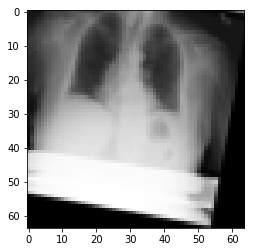

In [44]:
for x,p in RandTransLoader:
    plt.imshow(x.detach().numpy()[0][0],cmap="gray")
    
    
    
    

In [29]:
OtherXRayDir = "./OtherXray/MURA-v1.1/valid/"
OtherXRay = OtherXrayDataset(OtherXRayDir, isize=isize,nrows=1000)
print(len(OtherXRay))
otherxray = DataLoader(OtherXRay, shuffle=False, batch_size=batch_size)

KeyboardInterrupt: 

In [8]:

    
    
OtherXRayDir = "./chest_xray/"
Pneunomia = PneunomiaXray(OtherXRayDir, isize=isize,nrows=1000)
PneuLoader = DataLoader(Pneunomia, shuffle=False, batch_size=batch_size)

In [9]:

CP = -2 #Checkpoint to load (-2 for latest one, -1 for last epoch)
DisX,DisZ,DisXZ,GenZ,GenX,CP,DiscriminatorLoss,AllAUCs = GenModel(isize,LS,-2,ExpDir,name,ColorsNumber=ColorsNumber)

DisX = DisX.eval()
DisZ = DisZ.eval()
DisXZ = DisXZ.eval()
GenZ = GenZ.eval()
GenX = GenX.eval()



I found this last checkpoint 2121000


In [10]:
def RecLoss(GenX,GenZ,X):
    GenX.eval()
    GenZ.eval()
    Z = GenZ(X)
    Xr = GenX(Z)
    
    DiffX = Xr - X
    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]
    Xr = Xr.detach().numpy()
    Z = Z.detach().numpy()
    Z = Z.reshape(Z.shape[0],Z.shape[1])
    return(RecLoss,DiffX,Xr,Z)
#Generate Alpha Red Map (so transparent) for error


In [11]:
import time

ChestXray


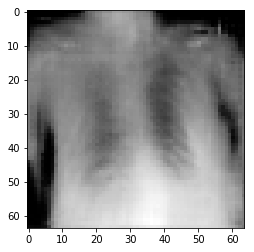

Random


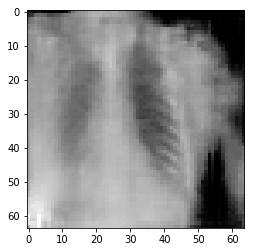

Pneumonia


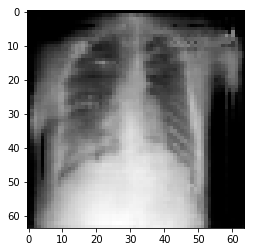

MURA


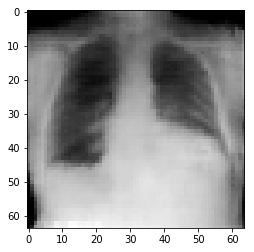

vFlip


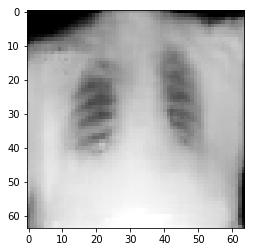

hFlip


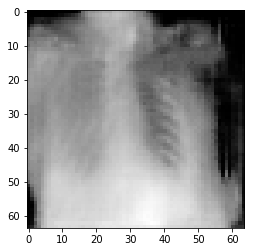

MNIST


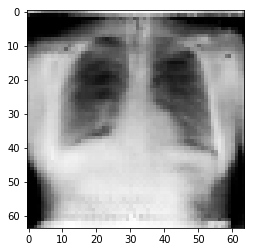

Permuted


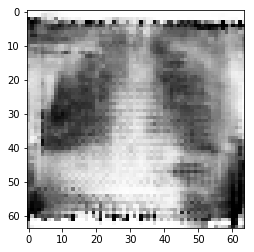

In [45]:

#AllLoader = [RealLoader,MNIST_loader,otherxray,hflip,vflip,randray,DiseaseLoader]
#Names = ["ChestXray","MNIST","MURA","hFlip","vFlip","Permuted","Disease"]

AllLoader = [RealLoader,RandTransLoader,PneuLoader,otherxray,hflip,vflip,MNIST_loader,randray]
Names = ["ChestXray","Random","Pneumonia","MURA","vFlip","hFlip","MNIST","Permuted"]

BenchData = dict()
test_size = 1000
for (load,name) in zip(AllLoader,Names):
    BenchData[name] = dict()
    
    print(name)
    
    AllRecL = []
    AllX = []
    AllXr = []
    AllPath = []
    AllErr = []
    AllLab = []
    AllZ = []
    endtime = time.time()
    for Xi,path in load:
        
        if name == "MNIST":
            path = path.detach().numpy()
        inittime = time.time()
        #print(inittime-endtime)
        Xn = Xi*2.0 - 1
        Rl,DiffX,Xr,Z = RecLoss(GenX,GenZ,Xn)
        AllErr += list(DiffX)
        AllXr += list(Xr)
        AllRecL += Rl
        AllX += list(Xn.detach().numpy())
        AllZ += list(Z)
        if len(path) == 2:
            AllPath += list([p.split("/")[-1] for p in path[0]])
            AllLab += list(path[1])
        else:
            AllLab += list(path)
        plt.imshow(Xr[0][0],cmap="gray")
        plt.show()
        break
        if len(AllRecL) > test_size:
            AllRecL = AllRecL[:test_size]
            AllErr = AllErr[:test_size]
            AllPath = AllPath[:test_size]
            AllLab = AllLab[:test_size]
            AllX = AllX[:test_size]
            AllZ = AllZ[:test_size]
            break
        endtime = time.time()
    BenchData[name]["RL"]   = AllRecL
    BenchData[name]["Diff"] = AllErr
    BenchData[name]["Path"] = AllPath
    BenchData[name]["Label"] = AllLab
    
    BenchData[name]["OriImg"] = AllX
    BenchData[name]["Z"] = AllZ


/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


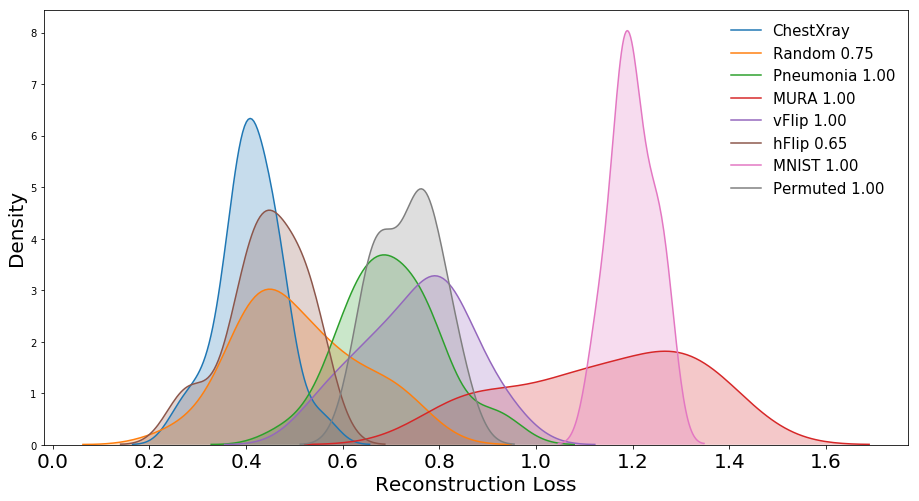

In [46]:
fig = plt.figure(figsize=(15.5,8))
SNScol = sns.color_palette()

for i,name in enumerate(Names):
    #Get Reconstruction loss
    TestRL = BenchData[name]["RL"]
    RealRL = BenchData["ChestXray"]["RL"]
    
    #Concat
    CatRl = RealRL + TestRL
    
    #Gen Label
    Lab = [1]*len(RealRL)+[0]*len(TestRL)
    
    #Get AUC
    fpr, tpr, thresholds = metrics.roc_curve(Lab,-np.array(CatRl), pos_label=1)
    auc = metrics.auc(fpr, tpr)
    lab =  "%s %.2f" % (name,auc)
    if name == "ChestXray":
        lab = name
    #plt.hist(TestRL,label=lab, density=True,histtype="step",bins=20,color=SNScol[i])
    sns.kdeplot(TestRL, shade=True,label=lab,color=SNScol[i])
#plt.legend(fontsize = 30,frameon=False,prop={"family":"Sans Serif"})
plt.legend(fontsize = 15,frameon=False)

plt.xlabel("Reconstruction Loss",size=20)
plt.ylabel("Density",size=20)
plt.xticks(size=20)
plt.show()

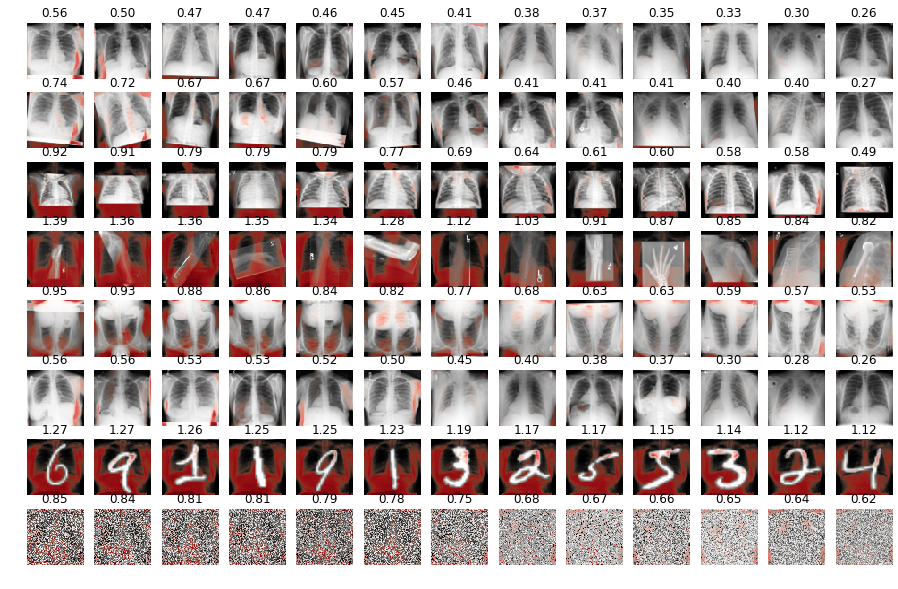

In [47]:
fig = plt.figure(figsize=(15.5,10))
c = 1
for i,name in enumerate(Names):
    RL = BenchData[name]["RL"]
    Diff = BenchData[name]["Diff"] 
    img = BenchData[name]["OriImg"]
    SortInd = np.argsort(RL)[::-1]
    RankPrint = [0,1,2,3,4,int(len(RL)/4),int(len(RL)/2),int(len(RL)/4*3),len(RL)-5,len(RL)-4,len(RL)-3,len(RL)-2,len(RL)-1]
    for rp in RankPrint:
        NowInd = SortInd[rp]
        plt.subplot(len(Names),len(RankPrint),c)
        plt.title("%.2f" % (RL[NowInd]))
        plt.imshow(img[NowInd][0],cmap="gray")
        plt.imshow(Diff[NowInd][0],cmap=AlphaRed,vmin=0, vmax=4)
        #plt.imshow(Diff[NowInd][0],cmap="gray")
        plt.axis("off")
        
        c += 1
plt.show()

In [15]:
AllZ = []
for i,name in enumerate(Names):
    AllZ += BenchData[name]["Z"]
Y = manifold.TSNE(n_components=2).fit_transform(AllZ)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(15.5,8))
minc = 0
maxc = 0
fig = plt.figure(figsize=(15.5,8))
for i,name in enumerate(Names):
    maxc += len(BenchData[name]["Z"])
    plt.scatter(Y[minc:maxc,0],Y[minc:maxc,1],label=name,s=4,color=SNScol[i])
    minc = maxc
plt.legend(fontsize = 15,frameon=False, markerscale=2)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15.5,8))
minc = 0
maxc = 0
fig = plt.figure(figsize=(15.5,8))
for i,name in enumerate(Names):
    maxc += len(BenchData[name]["Z"])
    plt.scatter(Y[minc:maxc,0],Y[minc:maxc,1],cmap=plt.cm.Blues,c=BenchData[name]["RL"],s=4)
    minc = maxc
#plt.legend(fontsize = 15,frameon=False, markerscale=2)
plt.colorbar()
plt.show()


In [ ]:
Y = manifold.TSNE(n_components=2).fit_transform(BenchData["ChestXray"]["Z"])

In [ ]:
fig = plt.figure(figsize=(15.5,8))
for l in list(pd.Series(BenchData["ChestXray"]["Label"]).value_counts()[:10].index):
    
    ind = np.array(BenchData["ChestXray"]["Label"]) == l

    plt.scatter(Y[ind,0],Y[ind,1],label=l)
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(15.5,8))
ind = np.array(BenchData["ChestXray"]["RL"]) < 0.6

plt.scatter(Y[:,0],Y[:,1],cmap=plt.cm.Blues,c=BenchData["ChestXray"]["RL"],s=5)
plt.colorbar()
plt.show()

In [ ]:
def OutScore(DisX,DisZ,DisXZ,GenZ,GenX,X):
    
    
    z = GenZ(X)
    Xr = GenX(z)
    
    #CatT= torch.cat((DisZ(z), DisX(X)), 1)
    #PredFalse = DisXZ(CatT)
    
    DiffX = Xr - X
    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]
    #PredFalse = PredFalse.detach().numpy()[0][0][0]
    #return(RecLoss,PredFalse)
    return(RecLoss)

In [ ]:
def TransformPImg(pim,inputsize,ar):
    tx = ar[0]
    ty = ar[1]
    rot = ar[2]
    sc = ar[3]
    brightness_factor = ar[4]
    contrast_factor = ar[5]
    tim = transforms.functional.affine(pim,angle=rot, translate=[tx,ty], 
                                                   scale=1, shear=0, resample=0, fillcolor=0)
    
    tim = transforms.functional.adjust_brightness(tim, brightness_factor)
    tim = transforms.functional.adjust_contrast(tim, contrast_factor)
    data_transforms = transforms.Compose([transforms.CenterCrop(sc)])
    ftim = data_transforms(tim)
    reim = transforms.functional.resize(ftim,inputsize)
    tim = transforms.functional.to_tensor(reim)
    tim = tim.reshape(1,1,inputsize,inputsize)
    return(ftim,tim)
    



In [ ]:


imgs = BenchData["ChestXray"]["Path"]
RandInt = 40
Explore = 5

fig = plt.figure(figsize=(15.5,8))
c = 0
for imgf in imgs:
    ptf = datadir + "images/"+ imgf
    im = misc.imread(ptf)
    if len(im.shape) > 2:
        im = im[:, :, 0]
    #Add color chanel
    im = im[:,:,None]
    
    pim = transforms.functional.to_pil_image(im)
    
    space  = [Integer(-200, 200, name='tx'),
          Integer(-200, 200, name='ty'),
          Real(-45,45, name='rot'),
          Integer(500, im.shape[0], name='sc'),
          Real(0.2,2.2, name='Bright'),
          Real(0.2,2.2, name='Contrast')
          ]
   
    
    
    opt = Optimizer(space)

    #Get random value
    
    
    
    
    Fimg = []
    Errs = []
    for it in range(Explore):
        RandTest = []
        
            
        totest = opt.ask(n_points=RandInt)
        RandTest += totest
        TensorTsc = torch.tensor([])
        for i in range(RandInt):
            FullImg,TensorImg = TransformPImg(pim,isize,RandTest[i])
            Fimg.append(FullImg)
            TensorTsc = torch.cat((TensorTsc,TensorImg),0)
        rl = OutScore(DisX,DisZ,DisXZ,GenZ,GenX,TensorTsc*2.0-1.0)
        for i in range(RandInt):
            opt.tell(RandTest[i], rl[i])
            print(rl[i],RandTest[i])
        Errs += rl
    break

In [ ]:
fig = plt.figure(figsize=(15.5,8))
c = 1
plt.subplot(5,9,c)
plt.imshow(pim,cmap="gray")
plt.title("%.2f" % (BenchData["ChestXray"]["RL"][0]))
plt.axis("off")
c += 1
for i in np.argsort(Errs):
    plt.subplot(5,9,c)
    plt.imshow(Fimg[i],cmap="gray")
    plt.title("%.2f" % (Errs[i]))
    plt.axis("off")
    c += 1
    if c > 5*9:
        break
plt.show()

In [ ]:


imgs = BenchData["ChestXray"]["Path"]
RL = BenchData["ChestXray"]["RL"]
RandInt = 20
Explore = 10


RandInt = 10
Explore = 10

fig = plt.figure(figsize=(15.5,8))
c = 0


SortInd = np.argsort(RL)[::-1]
RankPrint = [0,1,2,3,4,5,6,7,int(len(RL)/4),int(len(RL)/2),int(len(RL)/4*3),len(RL)-5,len(RL)-4,len(RL)-3,len(RL)-2,len(RL)-1]
for rp in RankPrint:
    ind = SortInd[rp]

    ptf = datadir + "images/"+ BenchData["ChestXray"]["Path"][ind]
    im = misc.imread(ptf)
    if len(im.shape) > 2:
        im = im[:, :, 0]
    #Add color chanel
    im = im[:,:,None]
    
    pim = transforms.functional.to_pil_image(im)
    
    space  = [Integer(-200, 200, name='tx'),
          Integer(-200, 200, name='ty'),
          Real(-5,5, name='rot'),
          Integer(500, im.shape[0], name='sc'),
          Real(0.8,1.2, name='Bright'),
          Real(0.8,1.2, name='Contrast')
          ]
   
    
    
    opt = Optimizer(space)

    #Get random value
    
    
    
    
    Fimg = []
    Errs = []
    for it in range(Explore):
        RandTest = []
        
            
        totest = opt.ask(n_points=RandInt)
        RandTest += totest
        TensorTsc = torch.tensor([])
        for i in range(RandInt):
            FullImg,TensorImg = TransformPImg(pim,isize,RandTest[i])
            Fimg.append(FullImg)
            TensorTsc = torch.cat((TensorTsc,TensorImg),0)
        rl = OutScore(DisX,DisZ,DisXZ,GenZ,GenX,TensorTsc*2.0-1.0)
        for i in range(RandInt):
            opt.tell(RandTest[i], rl[i])
            #print(rl[i],RandTest[i])
        Errs += rl
        
        tsort = np.argsort(Errs)
        Errs = [Errs[tsort[0]]]
        Fimg = [Fimg[tsort[0]]]
        BestXi = opt.Xi[np.argsort(opt.yi)[0]]
        print(it,BestXi,np.sort(opt.yi)[0],BenchData["ChestXray"]["RL"][ind])
    c += 1
    plt.subplot(4,8,c)
    plt.imshow(pim,cmap="gray")
    plt.title("%.2f" % (BenchData["ChestXray"]["RL"][ind]))
    plt.axis("off")  
    c += 1
    plt.subplot(4,8,c)    
    plt.imshow(Fimg[0],cmap="gray")
    plt.title("%.2f" % (Errs[0]))
    plt.axis("off")
    
    BestXi = opt.Xi[np.argsort(opt.yi)[0]]
    print(BestXi,np.sort(opt.yi)[0],BenchData["ChestXray"]["RL"][ind])
    
plt.show()